In [1]:
#subprocess를 사용하기 위한 패키지 불러오기
import subprocess
import sys

#subprocess로 패키지 설치하기
subprocess.call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'low_endgbm'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'catboost'])

0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta
import math

#같은 결과 출력을 위해 시드 고정하기
np.random.seed(2003)

In [3]:
train_data = pd.read_csv('train_data_20251024.csv', index_col=0)
test_data = pd.read_csv('test_data_20251024.csv', index_col=0)

### 1. 데이터 분할하기

In [5]:
#train_test_split 불러오기
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_data.drop('status', axis=1), train_data['status'], random_state=10, stratify=train_data['status'])

In [6]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((41250, 26), (13750, 26), (41250,), (13750,))

예측 대상으로 주어진 test_data도 label과 feature를 분리한다.

In [7]:
X_test = test_data.drop('status', axis=1)
Y_test = test_data['status']

In [8]:
X_test.shape, Y_test.shape,

((5000, 26), (5000,))

### 2. 모델별 성능 그래프 그리기

In [9]:
#성능 지표 계산을 위한 패키지 불러오기
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [10]:
result = pd.DataFrame( [], columns=['acc', 'recall', 'precision', 'F1-score'])

In [ ]:
#파라미터 
#model_name : 모델이름
#pred : 예측 결과
#actual : 실제값

In [16]:
def result_view(model_name, pred, actual) : 
    #정확도 
    acc = round(accuracy_score(actual, pred), 3)

    #정밀도
    precision = round(precision_score(actual, pred), 3)

    #재현율
    recall = round(recall_score(actual, pred), 3)

    #F1 Score
    F1 = round(f1_score(actual, pred), 3)

    result.loc[model_name] = (acc, recall, precision, F1)
    result.sort_values(by='acc', inplace=True, ascending=False)

    print(result)
    plt.figure(figsize=(8,5))

    for idx in result.index :
        x_values = result.columns
        y_values = result.loc[idx]
        plt.plot(x_values, y_values)

        plt.annotate(text=round(result.loc[idx, 'acc'], 3), xy=(0, result.loc[idx, 'acc']), xytext=(0, result.loc[idx, 'acc']), ha='center', fontsize=14)
        plt.annotate(text=round(result.loc[idx, 'recall'], 3), xy=(1, result.loc[idx, 'recall']), xytext=(1, result.loc[idx, 'recall']), ha='center', fontsize=14)
        plt.annotate(text=round(result.loc[idx, 'precision'], 3), xy=(2, result.loc[idx, 'precision']), xytext=(2, result.loc[idx, 'precision']), ha='center', fontsize=14)
        plt.annotate(text=round(result.loc[idx, 'F1-score'], 3), xy=(3, result.loc[idx, 'F1-score']), xytext=(3, result.loc[idx, 'F1-score']), ha='center', fontsize=14)

    plt.legend(result.index, loc=4)

    plt.show()

### 3. 모델 생성하기

라이브러리 불러오기 -> 모델 생성 -> 모델 학습 -> 결과 검증

1) 로지스틱 회귀

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
model_lr = LogisticRegression(random_state=21)

In [14]:
model_lr.fit(x_train, y_train)

LogisticRegression(random_state=21)

                       acc  recall  precision  F1-score
Logistic Regression  0.734   0.583       0.72     0.644


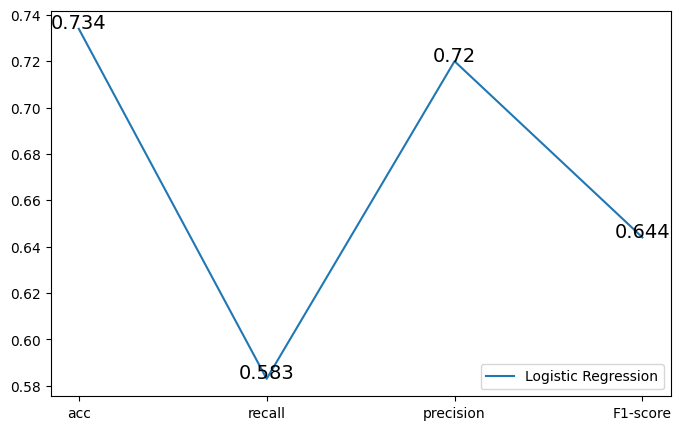

In [17]:
pred_lr = model_lr.predict(X_test)
result_view('Logistic Regression', pred_lr, Y_test)

2) KNN

학습 데이터를 좌표 평면에 표현한 후, 분류하고자 하는 데이터의 주변으로 가상의 원을 확장하다
발견되는 첫 번째 데이터의 그룹으로 분류하는 방법이다.
K 개의 의미는 가상의 원에 들어가는 K개의 데이터를 찾고,
그중에 가장 많은 데이터가 속한 그룹으로 분류한다는 뜻이다.

                       acc  recall  precision  F1-score
Logistic Regression  0.734   0.583      0.720     0.644
KNN                  0.718   0.609      0.677     0.641


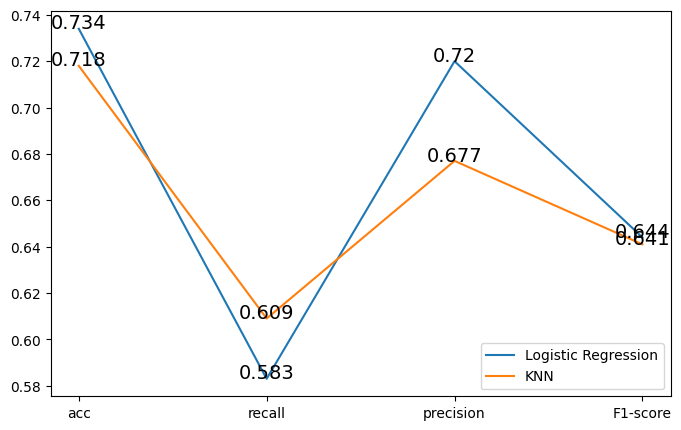

In [19]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)
pred_knn = model_knn.predict(X_test)
result_view('KNN', pred_knn, Y_test)

knn은 고차원에서 과대적합되기 쉽다는 단점이 있다.
knn의 과대적합을 피하기 위해 변수를 제한하여 선택하고, 차원 축소를 이용하는 것이 좋다.

3) SVM

SVM은 분류 모델에서 클래스를 구분하는 결정 경계와, 
이 평면에서 가장 가까운 훈련 샘플 사이의 거리(마진)를 
크게 하는 직선을 찾는 것이 원리이다.

마진이 커야, 새로운 샘플이 들어왔을 때, 기존에 그어진 결정 경계 안에 들어갈 가능성이 높다.

                          acc  recall  precision  F1-score
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


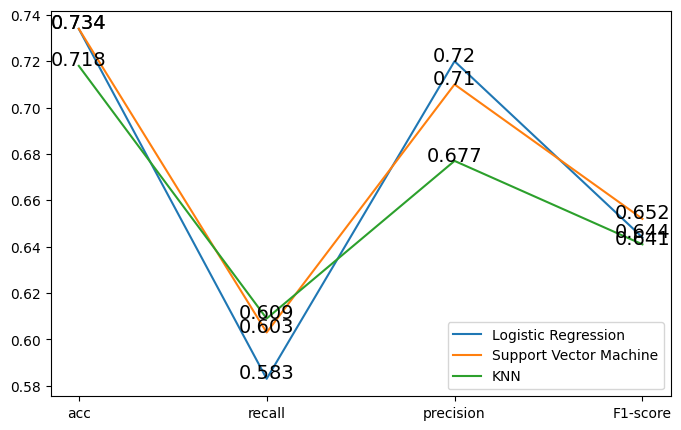

In [20]:
from sklearn.svm import SVC
model_svm = SVC(random_state=21)
model_svm.fit(x_train, y_train)
pred_svm = model_svm.predict(X_test)
result_view('Support Vector Machine', pred_svm, Y_test)

svm은 대량의 데이터에서는 느리고 성능이 좋지 않은 경향이 있다.
전처리와 매개변수 영향을 많이 받는다는 점을 고려하여 설정해야 한다.

4) 의사결정나무

                          acc  recall  precision  F1-score
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


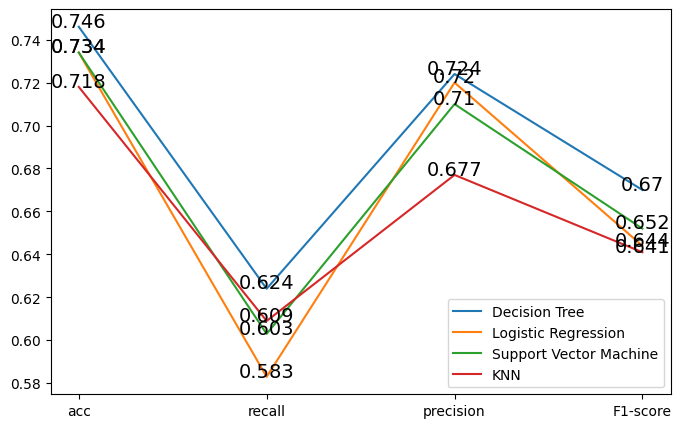

In [22]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=5, max_leaf_nodes=None, random_state=21)
model_dt.fit(x_train, y_train)
pred_dt = model_dt.predict(X_test)
result_view('Decision Tree', pred_dt, Y_test)

의사결정나무는 과대적합이 쉽게 발생하는 대신 직관적인 모델로 설명력이 높다.

5) 랜덤포레스트

                          acc  recall  precision  F1-score
Random Forest           0.755   0.638      0.736     0.683
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


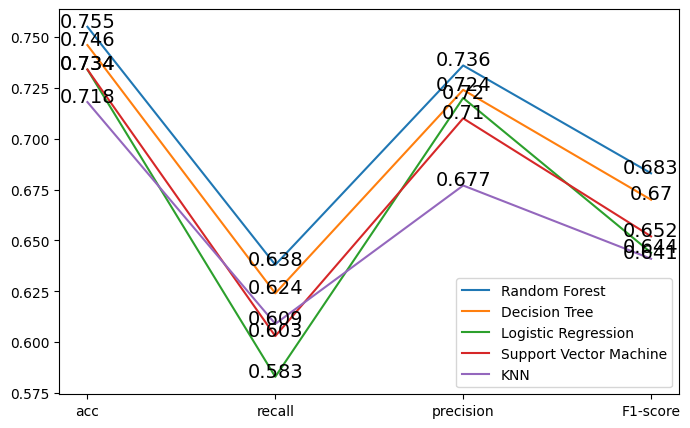

In [24]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                 
                                  max_depth=None,
                                  max_leaf_nodes=None,
                                  random_state=21)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(X_test)
result_view('Random Forest', pred_rf, Y_test)
                        

6) XGBoost

여러번 학습이 될 때, 잘못 예측된 데이터에 가중치를 부여하여 학습 시킨다.

In [28]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(learning_rate=0.1, n_jobs=-1, n_estimators=500, random_state=21, early_stopping_rounds=10, eval_metric='logloss')
start = time.time()

eval_set = [(x_val, y_val)]
model_xgb.fit(x_train, y_train,eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.65290
[1]	validation_0-logloss:0.62993
[2]	validation_0-logloss:0.61103
[3]	validation_0-logloss:0.59529
[4]	validation_0-logloss:0.58209
[5]	validation_0-logloss:0.57138
[6]	validation_0-logloss:0.56157
[7]	validation_0-logloss:0.55356
[8]	validation_0-logloss:0.54624
[9]	validation_0-logloss:0.54026
[10]	validation_0-logloss:0.53512
[11]	validation_0-logloss:0.53039
[12]	validation_0-logloss:0.52604
[13]	validation_0-logloss:0.52279
[14]	validation_0-logloss:0.51946
[15]	validation_0-logloss:0.51683
[16]	validation_0-logloss:0.51415
[17]	validation_0-logloss:0.51205
[18]	validation_0-logloss:0.50983
[19]	validation_0-logloss:0.50832
[20]	validation_0-logloss:0.50652
[21]	validation_0-logloss:0.50499
[22]	validation_0-logloss:0.50394
[23]	validation_0-logloss:0.50293
[24]	validation_0-logloss:0.50171
[25]	validation_0-logloss:0.50063
[26]	validation_0-logloss:0.49955
[27]	validation_0-logloss:0.49879
[28]	validation_0-logloss:0.49817
[29]	validation_0-loglos

0.051197632153828936

                          acc  recall  precision  F1-score
XGBoost                 0.764   0.640      0.753     0.692
Random Forest           0.755   0.638      0.736     0.683
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


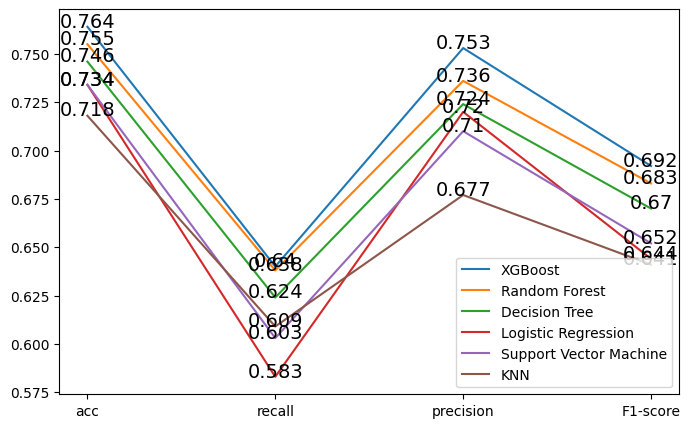

In [30]:
pred_xgb = model_xgb.predict(X_test)
result_view('XGBoost', pred_xgb, Y_test)

7) CatBoost

XGBoost와 마찬가지로 부스팅 알고리즘을 사용한다. 
CatBoost는 트리를 대칭적으로 구성하여 빠른 속도를 내는 것이
다른 부스팅 알고리즘과 차이점이다.
또한 내부 알고리즘에서 과대적합을 줄이도록 보완하고 있어서 
하이퍼 파라미터 튜닝에 민감하지 않다.

In [31]:
import time
start = time.time()

from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier(learning_rate=0.03, iterations=2000, random_state=21)
start = time.time()

train_dataset = Pool(data=x_train, label=y_train)
eval_dataset = Pool(data=x_val, label=y_val)

cat.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds=30)
(time.time()-start)/60

0:	learn: 0.6825266	test: 0.6824197	best: 0.6824197 (0)	total: 168ms	remaining: 5m 36s
1:	learn: 0.6730971	test: 0.6728398	best: 0.6728398 (1)	total: 182ms	remaining: 3m 1s
2:	learn: 0.6649256	test: 0.6645339	best: 0.6645339 (2)	total: 196ms	remaining: 2m 10s
3:	learn: 0.6568689	test: 0.6563148	best: 0.6563148 (3)	total: 209ms	remaining: 1m 44s
4:	learn: 0.6492707	test: 0.6486390	best: 0.6486390 (4)	total: 222ms	remaining: 1m 28s
5:	learn: 0.6412550	test: 0.6405227	best: 0.6405227 (5)	total: 236ms	remaining: 1m 18s
6:	learn: 0.6339193	test: 0.6330597	best: 0.6330597 (6)	total: 249ms	remaining: 1m 10s
7:	learn: 0.6278248	test: 0.6268817	best: 0.6268817 (7)	total: 262ms	remaining: 1m 5s
8:	learn: 0.6218379	test: 0.6207008	best: 0.6207008 (8)	total: 276ms	remaining: 1m
9:	learn: 0.6162434	test: 0.6150369	best: 0.6150369 (9)	total: 289ms	remaining: 57.5s
10:	learn: 0.6107489	test: 0.6093934	best: 0.6093934 (10)	total: 303ms	remaining: 54.8s
11:	learn: 0.6052808	test: 0.6038586	best: 0.6038

0.2643824259440104

                          acc  recall  precision  F1-score
Cat Boost               0.765   0.641      0.754     0.693
XGBoost                 0.764   0.640      0.753     0.692
Random Forest           0.755   0.638      0.736     0.683
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


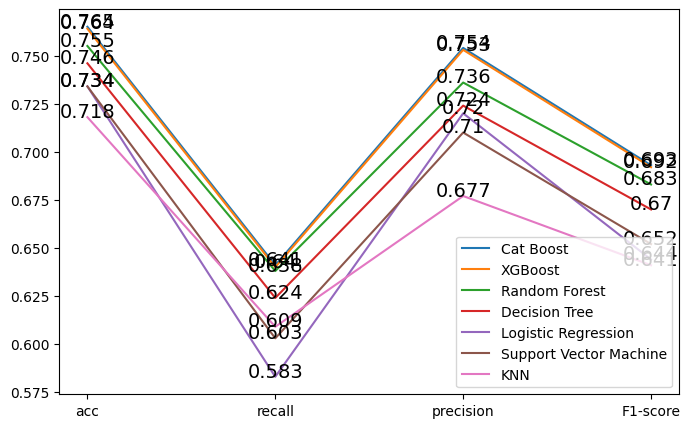

In [32]:
pred_cat = cat.predict(X_test)
result_view('Cat Boost', pred_cat, Y_test)

8) DNN

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [34]:
x_train.shape, y_train.shape

((41250, 26), (41250,))

In [39]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
dnn = Sequential()
dnn.add(Dense(8, activation='relu', input_shape=(26,), kernel_initializer=initializer))
dnn.add(Dropout(0.2))
dnn.add(Dense(2, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation='sigmoid'))

In [40]:
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 216       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 2)                 18        
                                                                 
 dropout_3 (Dropout)         (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 237
Trainable params: 237
Non-trainable params: 0
_________________________________________________________________


In [41]:
dnn.compile(optimizer='adam'
            ,loss='binary_crossentropy'
            ,metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

check_point = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)

history = dnn.fit(x=x_train, y=y_train,
                  epochs=50,
                  batch_size=20,
                  validation_data=(x_val, y_val),
                  verbose=1,
                  callbacks=[early_stop, check_point])

Epoch 1/50
2060/2063 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6251
Epoch 1: val_loss improved from inf to 0.59925, saving model to best_model.h5
2063/2063 [==============================] - 5s 2ms/step - loss: 0.6485 - accuracy: 0.6251 - val_loss: 0.5993 - val_accuracy: 0.7073
Epoch 2/50
2029/2063 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.6663
Epoch 2: val_loss improved from 0.59925 to 0.57041, saving model to best_model.h5
2063/2063 [==============================] - 4s 2ms/step - loss: 0.6090 - accuracy: 0.6665 - val_loss: 0.5704 - val_accuracy: 0.7289
Epoch 3/50
2041/2063 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.6846
Epoch 3: val_loss improved from 0.57041 to 0.55700, saving model to best_model.h5
2063/2063 [==============================] - 4s 2ms/step - loss: 0.5951 - accuracy: 0.6846 - val_loss: 0.5570 - val_accuracy: 0.7303
Epoch 4/50
2044/2063 [============================>.] - ETA: 0s -

157/157 [==============================] - 0s 1ms/step
                          acc  recall  precision  F1-score
Cat Boost               0.765   0.641      0.754     0.693
XGBoost                 0.764   0.640      0.753     0.692
Random Forest           0.755   0.638      0.736     0.683
Decision Tree           0.746   0.624      0.724     0.670
DNN                     0.745   0.595      0.737     0.659
Logistic Regression     0.734   0.583      0.720     0.644
Support Vector Machine  0.734   0.603      0.710     0.652
KNN                     0.718   0.609      0.677     0.641


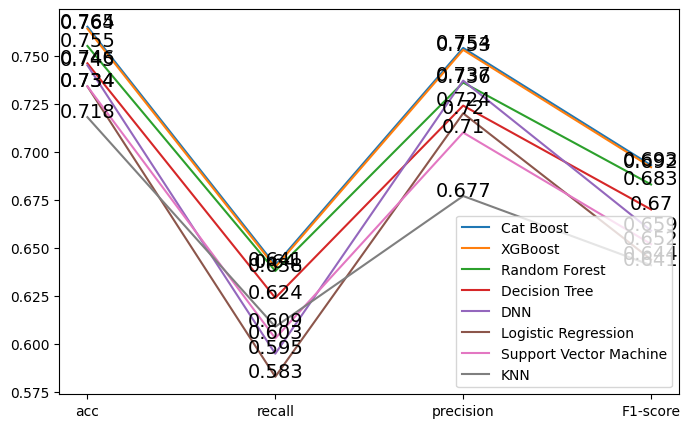

In [43]:
pred_dnn = (dnn.predict(X_test) > 0.5).astype("int32")
pred_dnn = pred_dnn.reshape(1, -1)[0]
result_view('DNN', pred_dnn, Y_test)

DNN 모델은 다른 모델에 비해 정밀도가 매우 높게 나왔다.
이 모델은 히든레이어를 어떻게 구성하느냐에 따라 성능 차이가 크다.

### 4. AI 모델 평가하기

1) 혼동 행렬

In [44]:
def show_confusion_matrix(labels, y_true, y_pred, title) : 
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=labels,
                yticklabels=labels, cmap=plt.cm.Blues, linecolor='black')
    plt.text(1,2.3,'Predicted', size=15, ha='center')
    plt.text(-0.3,1, 'True',rotation=90, size=15,ha='center')
    plt.title(title)
    plt.show()

labels=['해지', '유지']

C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\l

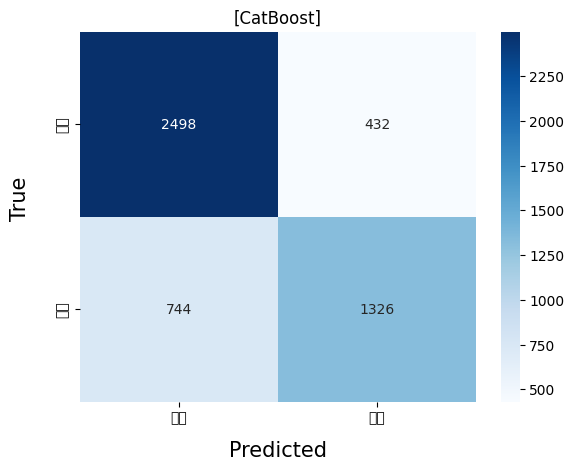

C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\l

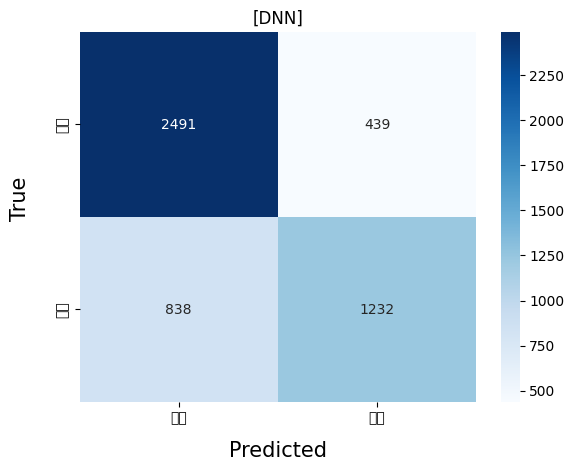

(None,)

In [45]:
show_confusion_matrix(labels, Y_test, pred_cat, '[CatBoost]'), 
show_confusion_matrix(labels, Y_test, pred_dnn, '[DNN]'), 

2) ROC와 AUC

In [46]:
from sklearn.metrics import roc_curve, auc

#파라미터
#y_pred : 원핫 인코딩된 2차원 이상 numpy.array
#y_true : 실제값
#y_label : label값

def plot_multiclass_roc(y_pred, y_true, y_label) :
    #빈 dictionary 생성하기
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    #roc_curve()의 입력값으로, y_true의 가변수 생성하기
    y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(len(y_label)) :
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #각 클래스에 대한 roc 계산하기
    fig, ax =plt.subplots(figsize=(17, 10))
    ax.plot([0,1], [0,1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(len(y_label)) :
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y_label[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    

C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


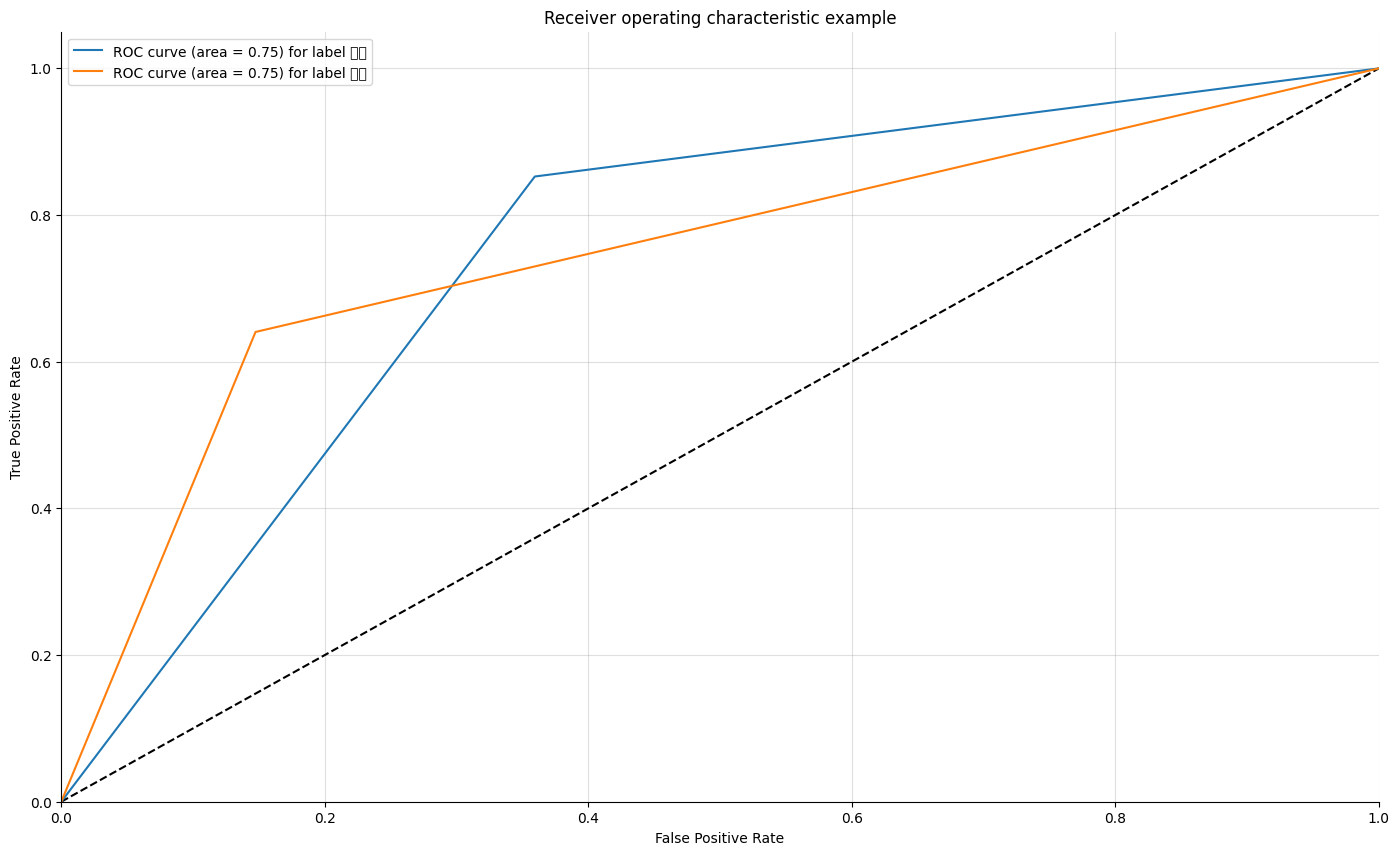

In [47]:
plot_multiclass_roc(pd.get_dummies(pred_cat).to_numpy(), Y_test, labels)

roc 그래프는 분류 모델의 확률 임계값 변화에 따른 그래프인데, 예측 결과인 pred_cat이 0,1로 이루어진 정수 형태여서 직선 그래프로 보인다.
이럴 때는 확률값을 그대로 입력값으로 사용하면 된다.

C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


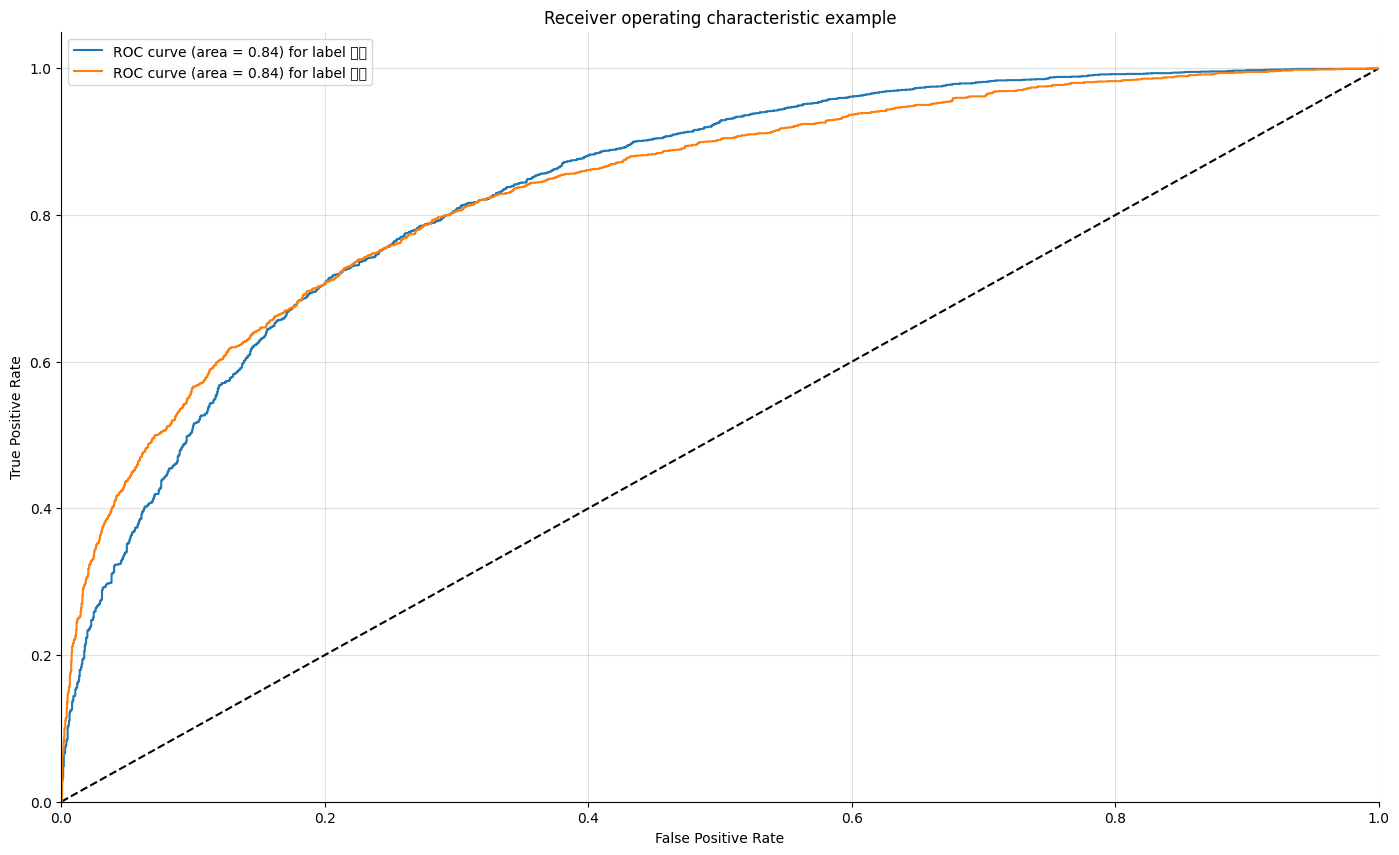

In [48]:
pred_cat_proba = cat.predict_proba(X_test)
plot_multiclass_roc(pred_cat_proba, Y_test, labels)